# CPSC 330 - Applied Machine Learning 

## Homework 6: Putting it all together 
### Associated lectures: All material till lecture 13 

**Due date: Wednesday, March 15, 2023 at 11:59pm**

## Table of contents

- [Submission instructions](#si)
- [Understanding the problem](#1)
- [Data splitting](#2)
- [EDA](#3)
- (Optional) [Feature engineering](#4)
- [Preprocessing and transformations](#5)
- [Baseline model](#6)
- [Linear models](#7)
- [Different classifiers](#8)
- (Optional) [Feature selection](#9)
- [Hyperparameter optimization](#10)
- [Interpretation and feature importances](#11)
- [Results on the test set](#12)
- (Optional) [Explaining predictions](#13)
- [Summary of the results](#14)

## Imports 

In [22]:
import os

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC

from pandas_profiling import ProfileReport
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFECV
import eli5
import shap
from sklearn.metrics import classification_report

<br><br>

## Instructions 
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2022W2/blob/main/docs/homework_instructions.md). 

**You may work on this homework in a group and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 3. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br>

## Introduction <a name="in"></a>
<hr>

At this point we are at the end of supervised machine learning part of the course. So in this homework, you will be working on an open-ended mini-project, where you will put all the different things you have learned so far together to solve an interesting problem.

A few notes and tips when you work on this mini-project: 

#### Tips

1. This mini-project is open-ended, and while working on it, there might be some situations where you'll have to use your own judgment and make your own decisions (as you would be doing when you work as a data scientist). Make sure you explain your decisions whenever necessary. 
2. **Do not include everything you ever tried in your submission** -- it's fine just to have your final code. That said, your code should be reproducible and well-documented. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code. 
3. If you realize that you are repeating a lot of code try to organize it in functions. Clear presentation of your code, experiments, and results is the key to be successful in this lab. You may use code from lecture notes or previous lab solutions with appropriate attributions. 
4. If you are having trouble running models on your laptop because of the size of the dataset, you can create your train/test split in such a way that you have less data in the train split. If you end up doing this, please write a note to the grader in the submission explaining why you are doing it.  

#### Assessment

We plan to grade fairly and leniently. We don't have some secret target score that you need to achieve to get a good grade. **You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results.** For example, if you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.

#### A final note

Finally, this style of this "project" question is different from other assignments. It'll be up to you to decide when you're "done" -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps "a few hours" (2-8 hours???) is a good guideline for a typical submission. Of course if you're having fun you're welcome to spend as much time as you want! But, if so, try not to do it out of perfectionism or getting the best possible grade. Do it because you're learning and enjoying it. Students from the past cohorts have found such kind of labs useful and fun and I hope you enjoy it as well. 

<br><br>

## 1. Understanding the problem <a name="1"></a>
<hr>
rubric={points:4}

In this mini project, you will be working on a classification problem of predicting whether a customer will cancel the reservation they have made at a hotel. 
For this problem, you will use [Reservation Cancellation Prediction Dataset](https://www.kaggle.com/datasets/gauravduttakiit/reservation-cancellation-prediction?select=train__dataset.csv). In this data set, there are about 18.000 examples and 18 features (including the target), and the goal is to estimate whether a person will cancel their booking; this column is labeled "booking_status" in the data (1 = canceled). 

**Your tasks:**

1. Spend some time understanding the problem and what each feature means. You can find this information in the documentation on [the dataset page on Kaggle](https://www.kaggle.com/datasets/gauravduttakiit/reservation-cancellation-prediction?select=train__dataset.csv). Write a few sentences on your initial thoughts on the problem and the dataset. 
2. Download the dataset and read it as a pandas dataframe. 

**ANS:** When first reading the dataset, I definitely understood the purpose and need for a supervised model that could predict whether a reservation would be cancelled or not. On a practical standpoint though, I wonder how usable these results would be for an actual hotel. If they trusted the model and booked another set of customers for the room assuming the current customers wouldn't come, this could have some serious False Negative implications. FN is definitely the metric I think this model should account for, especially hearing the negative effects of overbooking not only for hotels but for services like airplanes. 

With the actual dataset, I can see how these features could predict the cancellation of a customer's booking. 

In [23]:
rcp_df = pd.read_csv("train__dataset.csv")
rcp_df

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,4,0,0,0,118,2017,12,28,1,0,0,0,110.80,2,0
1,2,1,0,2,0,0,0,17,2018,4,14,1,0,0,0,145.00,0,1
2,1,0,1,5,0,0,0,349,2018,10,4,0,0,0,0,96.67,0,1
3,1,0,2,4,0,0,0,69,2018,6,12,0,0,0,0,120.00,0,1
4,2,0,0,4,1,0,0,11,2018,1,20,1,0,0,0,69.50,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18132,1,0,0,2,0,0,0,103,2018,4,19,0,0,0,0,115.00,0,1
18133,2,0,0,3,0,0,0,129,2018,8,10,1,0,0,0,88.01,1,0
18134,2,0,0,1,0,0,0,90,2018,7,13,1,0,0,0,105.30,0,1
18135,2,0,0,3,0,0,0,18,2018,11,10,1,1,0,1,123.33,1,0


<br><br>

## 2. Data splitting <a name="2"></a>
<hr>
rubric={points:2}

**Your tasks:**

1. Split the data into train and test portions. 

In [24]:
# 80/20 split
train_df, test_df = train_test_split(rcp_df, test_size=0.2, random_state=123)

<br><br>

## 3. EDA <a name="3"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

In [25]:
train_df.describe(include="all")

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
count,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000
mean,1.849059,0.107106,0.809566,2.196223,0.319526,0.032532,0.337859,85.211524,2017.821628,7.422979,15.711765,0.803708,0.025364,0.022331,0.153629,103.558628,0.621476,0.325867
std,0.514970,0.398989,0.869672,1.414027,0.630462,0.177413,0.775620,86.901659,0.382839,3.079938,8.759235,0.644105,0.157232,0.359667,1.720322,35.546998,0.789420,0.468714
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,16.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,0.000000,80.300000,0.000000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,1.000000,0.000000,0.000000,0.000000,99.450000,0.000000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,0.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,1.000000,0.000000,0.000000,0.000000,120.600000,1.000000,1.000000
max,4.000000,3.000000,7.000000,17.000000,3.000000,1.000000,6.000000,443.000000,2018.000000,12.000000,31.000000,4.000000,1.000000,13.000000,58.000000,540.000000,5.000000,1.000000


In [26]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14509 entries, 800 to 15725
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          14509 non-null  int64  
 1   no_of_children                        14509 non-null  int64  
 2   no_of_weekend_nights                  14509 non-null  int64  
 3   no_of_week_nights                     14509 non-null  int64  
 4   type_of_meal_plan                     14509 non-null  int64  
 5   required_car_parking_space            14509 non-null  int64  
 6   room_type_reserved                    14509 non-null  int64  
 7   lead_time                             14509 non-null  int64  
 8   arrival_year                          14509 non-null  int64  
 9   arrival_month                         14509 non-null  int64  
 10  arrival_date                          14509 non-null  int64  
 11  market_segmen

In [1]:
# removed as makes file too large
# profile = ProfileReport(train_df, title="RCF Report")
# profile

**ANS:** <br>
2 Summary Statistics 
1. Mean of children vs Mean of Adults: <br>
Adult: 1.849059 Children: 0.107106 I thought this summary statistic was useful as there was a much lesser amount of children staying at the hotel compared to the adults, which could affect an adult's decision to cancel the reservation based on the dependence of other people they bring with them. The mean of the adults itself being closer to 2 also could be a factor in this observation.
<br>
2. Lead Time std: <br>
The std for lead time 86.901659 is much higher compared to the other features, which could skew the predictions of the model as the data can vary much greater. This also shows how we should scale the data as the numerical values differ greatly
<br>

2 Visualizations
<br>
1. Arrival month histogram <br>
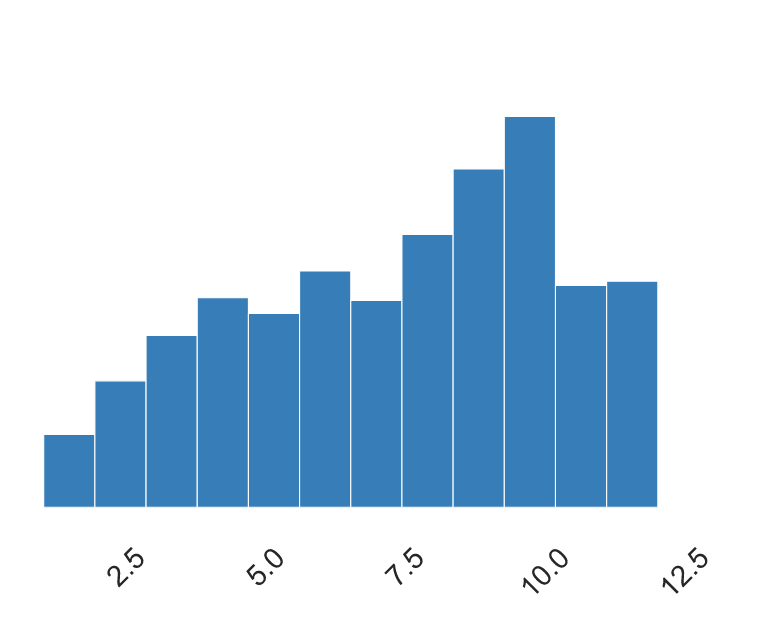
This shows that most of the arrivals were in the months of 7-10, which may be a factor as to whether a customer is more willingly to cancel their reservation if it is during a time where hotel bookings are more competitive.
<br>
2. Correlation Diagram <br>
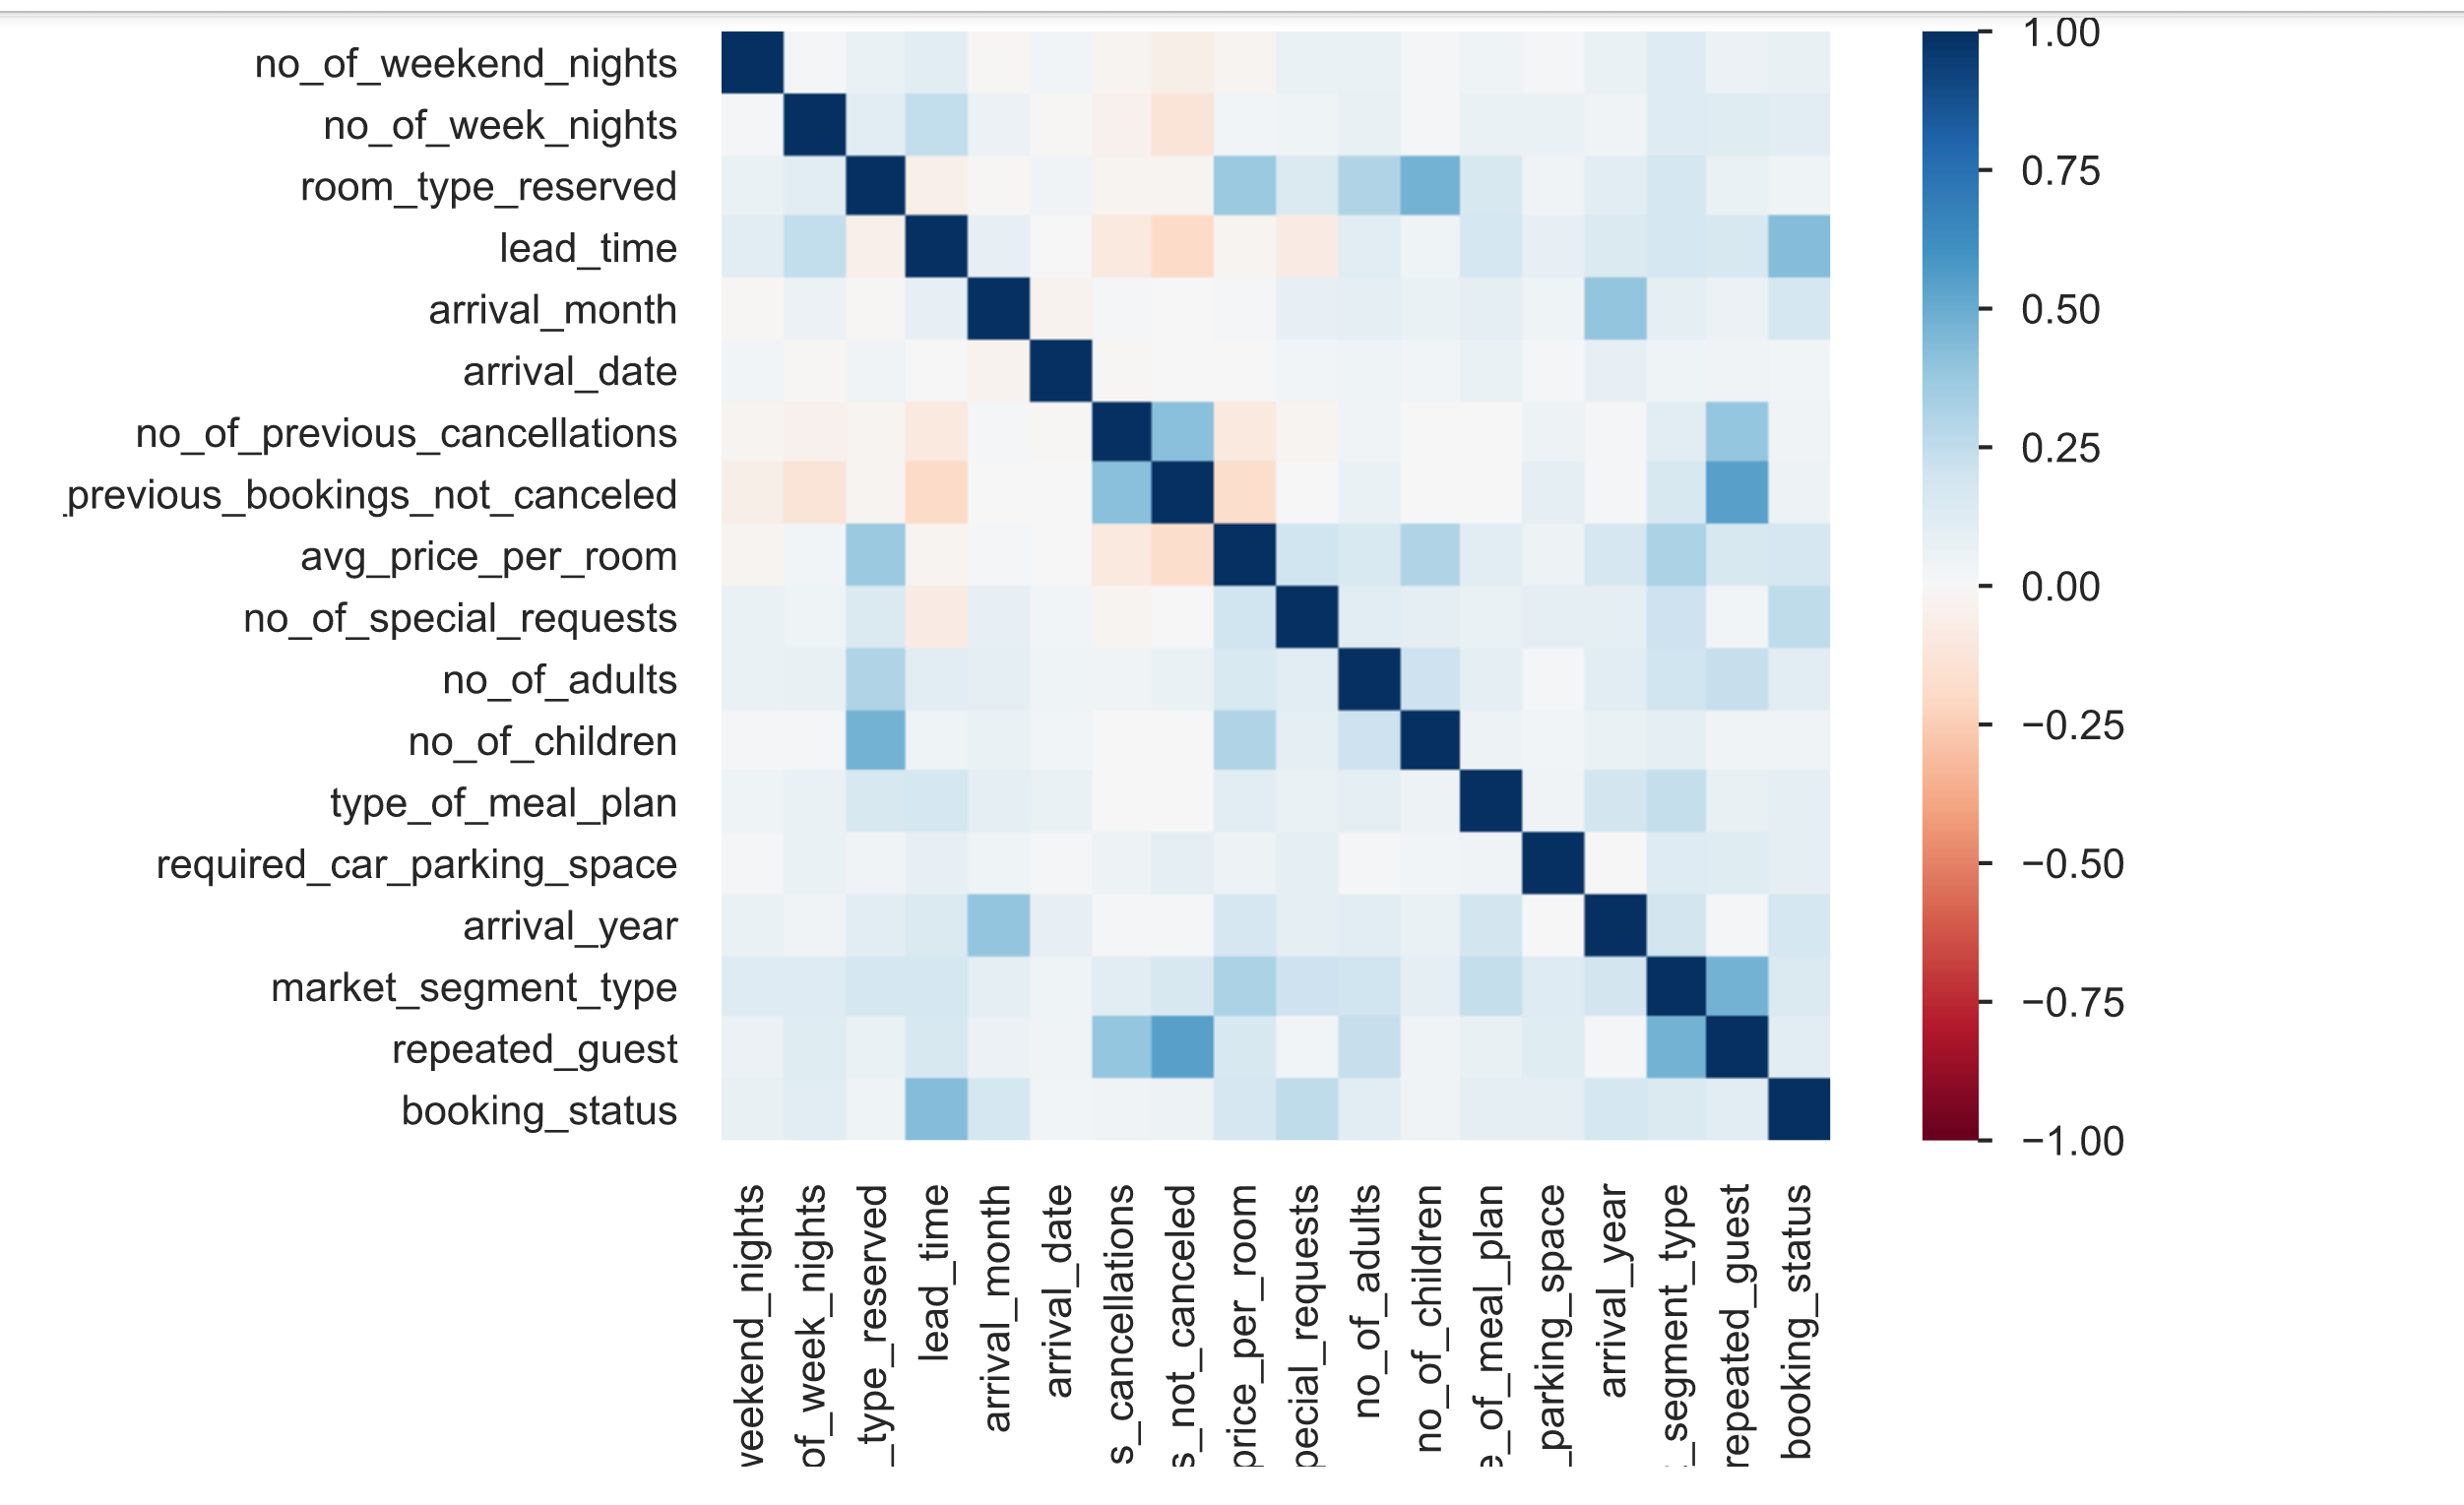
Useful for seeing which features are more dependent on each other, which could affect the scoring when doing feature engineering.

**ANS:** 
1. **Summary:** All of the features in this dataset are numerical, but some are actually categorical in nature. For example, the arrival year only has values of either 2017 or 2018. It wouldn't make sense to treat the year as numerical data, so we can look at it as a category. There was also a feature I didn't really understand which was market_segment_type, even after reading the Kaggle description. However, just looking at the data there are only 5 possible values, so I will assume that is also a form of categorical data. I also noticed a lot of class imbalance in features such as required car parking space, as most people don't require a parking space (14037 vs 472). This may lead to some problems in the model, so I will try to keep it in mind when setting hyperparameters. There are also no missing values so imputation isn't necessary. Finally, as always we should scale the numerical data as I can see for certain features like lead time or the average pricing, those values are on a different scale and can greatly affect the model. 
<br> <br>
2. **Metrics:** As mentioned previous in the introduction of the problem, in the real world there would be more negative effects from following through a prediction that a customer will cancel and overbooking. This would greatly harm the reputation of the hotel and cause customer churn, so it is worse to have False Positives rather than False Negatives. This means that we want to be more accurate with what we predict as positive, and should prioritize the metric of precision rather than recall. Accuracy may still useful in this problem as well as f1 score for the overall precision recall balance, however the main metric I will use is precision.

In [28]:
scoring = ["accuracy", "f1", "recall", "precision"]

<br><br>

## (Optional) 4. Feature engineering <a name="4"></a>
<hr>
rubric={points:1}

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing. 

**ANS:** While the data contains the number of adults and children separately, I believe it may be useful to have the total number of people as it's own separate feature. Hence I will create another feature column "no_of_people" with the sum of the adults and children.

In [29]:
train_df['no_of_people'] = train_df["no_of_adults"] + train_df["no_of_children"]
test_df['no_of_people'] = test_df["no_of_adults"] + test_df["no_of_children"]

train_df

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,no_of_people
800,2,0,1,3,0,0,0,23,2018,1,7,1,0,0,0,87.00,2,0,2
13544,1,0,0,1,0,0,0,15,2018,2,19,2,0,0,0,81.00,0,0,1
14555,1,0,1,1,0,0,0,3,2017,11,23,2,1,0,1,65.00,0,0,1
11224,2,0,0,2,0,0,1,148,2018,7,8,1,0,0,0,136.80,1,1,2
10890,2,1,2,4,0,0,0,61,2018,7,23,1,0,0,0,121.50,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13435,2,0,1,2,0,0,4,94,2018,3,25,1,0,0,0,95.25,0,0,2
7763,2,0,0,4,0,0,1,33,2018,2,23,1,0,0,0,61.60,1,0,2
15377,2,0,1,4,0,0,1,34,2018,4,4,1,0,0,0,131.40,0,1,2
17730,2,0,0,2,0,0,0,12,2017,12,16,0,0,0,0,58.00,0,0,2


<br><br>

## 5. Preprocessing and transformations <a name="5"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 

In [30]:
# numerical features that require scaling
numeric_features = ["no_of_adults", "no_of_children", "no_of_weekend_nights", "no_of_week_nights", 
                    "lead_time", "no_of_previous_cancellations", "no_of_previous_bookings_not_canceled", 
                    "avg_price_per_room", "no_of_special_requests", "no_of_people"] # StandardScaler()

# seems numerical but actually categorical as discussed in EDA
categorical_features = ["type_of_meal_plan", "room_type_reserved", "arrival_year", "arrival_month", 
                        "arrival_date", "market_segment_type"] # OHE (drop="if_binary") since arrival year technically only has 2 values

# with values of 0 and 1 for yes or no
binary_features = ["required_car_parking_space", "repeated_guest"] # already in binary column form, can pass through

target = "booking_status"

In [31]:
# column transformer preprocessor
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    ("passthrough", binary_features),
    (
        OneHotEncoder(drop="if_binary", sparse=False, handle_unknown='ignore'),
        categorical_features,
    )
)

In [32]:
X_train, y_train = train_df.drop(columns=[target]), train_df[target]
X_test, y_test = test_df.drop(columns=[target]), test_df[target]

<br><br>

## 6. Baseline model <a name="6"></a>
<hr>

rubric={points:2}

**Your tasks:**
1. Try `scikit-learn`'s baseline model and report results.

In [33]:
pipe_dummy = make_pipeline(
    preprocessor, DummyClassifier(strategy="prior"),
)

cross_val_dummy = pd.DataFrame (
    cross_validate(pipe_dummy, X_train, y_train, return_train_score=True)
)

cross_val_dummy.mean()

fit_time       0.030719
score_time     0.012965
test_score     0.674133
train_score    0.674133
dtype: float64

**ANS:** Based on the results of the DummyClassifier, this is the score (0.674) that we should expect to get. It is merely predicting the most common value, which isn't irregularly high or low. However it's important to note that this is the accuracy scoring metric not the precision.

<br><br>

## 7. Linear models <a name="7"></a>
<hr>
rubric={points:12}

**Your tasks:**

1. Try logistic regression as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the complexity hyperparameter `C`. 
3. Report validation scores along with standard deviation. 
4. Summarize your results.

In [34]:
pipe_lr = make_pipeline(
    preprocessor, LogisticRegression(max_iter=1000, random_state=123),
)

C_vals = [0.00001, 0.0001, 0.001, 0.01, 0.1]

param_grid = {
    "logisticregression__C": C_vals,
}

grid_search = GridSearchCV(
    pipe_lr, param_grid, cv=5, n_jobs=-1, return_train_score=True, scoring=scoring, refit=False
)

grid_search.fit(X_train, y_train)

results = pd.DataFrame(grid_search.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,...,mean_test_precision,std_test_precision,rank_test_precision,split0_train_precision,split1_train_precision,split2_train_precision,split3_train_precision,split4_train_precision,mean_train_precision,std_train_precision
0,0.146011,0.051666,0.053456,0.019733,0.00001,{'logisticregression__C': 1e-05},0.674363,0.674018,0.674018,0.674018,...,0.000000,0.000000,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.153394,0.038148,0.035502,0.002147,0.0001,{'logisticregression__C': 0.0001},0.676430,0.675741,0.676775,0.675052,...,0.931429,0.085905,1,0.962963,1.000000,0.960000,0.967742,0.925926,0.963326,0.023556
2,0.123871,0.003241,0.038694,0.003697,0.001,{'logisticregression__C': 0.001},0.781875,0.783253,0.787733,0.777739,...,0.800313,0.009455,2,0.797837,0.802481,0.798667,0.801602,0.801334,0.800384,0.001801
3,0.202858,0.007919,0.034707,0.002221,0.01,{'logisticregression__C': 0.01},0.803584,0.806685,0.806685,0.800138,...,0.748676,0.008502,3,0.754642,0.748259,0.760549,0.751497,0.751902,0.753370,0.004122
4,0.394345,0.011944,0.035504,0.003710,0.1,{'logisticregression__C': 0.1},0.807719,0.816678,0.812543,0.803928,...,0.745424,0.007608,4,0.747537,0.747570,0.748904,0.751018,0.747208,0.748447,0.001411


In [35]:
summary_results = {"C_vals" : C_vals,
                   "mean_test_precision" : results["mean_test_precision"], 
                   "mean_test_accuracy" : results["mean_test_accuracy"],
                   "mean_test_recall" : results["mean_test_recall"],
                   "mean_test_f1" : results["mean_test_f1"],
                   "std_test_precision" : results["std_test_precision"]}
pd.DataFrame(data=summary_results).set_index("C_vals")

,mean_test_precision,mean_test_accuracy,mean_test_recall,mean_test_f1,std_test_precision
C_vals,,,,,
0.00001,0.000000,0.674133,0.000000,0.000000,0.000000
0.00010,0.931429,0.676201,0.006768,0.013437,0.085905
0.00100,0.800313,0.783238,0.446279,0.572883,0.009455
0.01000,0.748676,0.803294,0.596868,0.664127,0.008502
0.10000,0.745424,0.809773,0.632190,0.684081,0.007608


**ANS:** As shown by the results of the exhaustive grid search, by looking at our target metric of precision, row 2 has the best precision score of 0.931429. This has the corresponding C score of 0.0001. The cross validation scores and standard deviation are also shown in the results table above. However by looking at the other metrics, we can see that the accuracy is very low, similar to the dummy tester. The recall is also very low which means we aren't predicting many positive values. However since I believe that precision is more important, I will prioritize that metric. After looking at the above table, I actually believe row 3 with C=0.001 and a precision score of 0.8003 to actually be the best hyperparameter. This is because although we sacrifice a bit of the precision, the f1 score is much better from C=0.0001 (0.56 difference) and I still want my model to be able to predict positive values. 
<br>
I chose to use exhaustive grid search since there was only one hyperparameter I was optimizing, which wouldn't be as taxing of a search. I also believe my bounds were a good range since the C value was in the middle of the values and not too small or large from my range. 

<br><br>

## 8. Different classifiers <a name="8"></a>
<hr>
rubric={points:15}

**Your tasks:**
1. Try at least 3 other models aside from logistic regression. At least one of these models should be a tree-based ensemble model (e.g., lgbm, random forest, xgboost). 
2. Summarize your results. Can you beat logistic regression? 

In [36]:
# 1. SVM RBF

pipe_svm = make_pipeline(
    preprocessor, SVC(random_state=123)
)

cross_val_svm = pd.DataFrame (
    cross_validate(pipe_svm, X_train, y_train, return_train_score=True, scoring=scoring)
)

In [37]:
# 2. RandomForestClassifier

pipe_rf = make_pipeline(
    preprocessor, RandomForestClassifier(random_state=123, n_jobs=-1)
)

cross_val_rf = pd.DataFrame (
    cross_validate(pipe_rf, X_train, y_train, return_train_score=True, scoring=scoring)
)

In [38]:
# 3. LightGBM

pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123))

cross_val_lgbm = pd.DataFrame (
    cross_validate(pipe_lgbm, X_train, y_train, return_train_score=True, scoring=scoring)
)

In [39]:
summary = {
    "svm" : cross_val_svm.mean(),
    "rf" : cross_val_rf.mean(),
    "lgbm" : cross_val_lgbm.mean(),
}

pd.DataFrame(data=summary)

,svm,rf,lgbm
fit_time,5.551157,0.616257,0.227391
score_time,1.867378,0.095277,0.030718
test_accuracy,0.846716,0.885933,0.882280
train_accuracy,0.868375,0.996519,0.906024
test_f1,0.746274,0.815100,0.811932
train_f1,0.782842,0.994652,0.850601
test_recall,0.691838,0.771575,0.779823
train_recall,0.728161,0.993337,0.820960
test_precision,0.810365,0.864018,0.846925
train_precision,0.846511,0.995971,0.882482


**ANS:** By looking at the summary of results in the table above, I find that the RandomForestClassifier is the best model.
1. Accuracy Scores: svm: 0.846716 < rf: 0.885933 > lgbm: 0.882280 > lr: 0.783238
2. Recall Scores: svm: 0.691838 <  rf: 0.771575 < lgbm: 0.779823 > lr: 0.446279
3. f1 Scores: svm: 0.746274  < rf: 0.815100 > lgbm: 0.811932 > lr: 0.572883
4. Precision Scores: svm: 0.810365 < rf: 0.864018 > lgbm: 0.846925 > lr: 0.800313
<br><br>
For all of the metrics except recall, rf has the best score. Since we also care more about precision than recall, we can disregard the result of recall being higher for lgbm. This shows that the rf classifier has the best overall results, and highest precision. Compared to the previous LogisticRegression model with a C=0.001, all of these models have higher scores. They all "beat" logistic regression.

<br><br>

## (Optional) 9. Feature selection <a name="9"></a>
<hr>
rubric={points:1}

**Your tasks:**

Make some attempts to select relevant features. You may try `RFECV` or forward selection. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises. 

In [40]:
# took too long to run
# pipe_forward = make_pipeline(
#     preprocessor,
#     SequentialFeatureSelector(LogisticRegression(max_iter=1000), 
#                               direction="forward", 
#                               n_features_to_select='auto', 
#                               tol=None),
#     RandomForestClassifier(random_state=123),
# )
# pd.DataFrame(
#     cross_validate(pipe_forward, X_train, y_train, return_train_score=True, n_jobs=-1)
# ).mean()

In [41]:
# feature_comp = {
#     "feature selected" : feature_selected,
#     "rf no selected" : summary["rf"]
# }

# pd.DataFrame(data=feature_comp)

**ANS:** I used forward selection with logistic regression for my feature selection. When comparing the results of the feature selection vs no feature selection, I feel that overall the non feature selected version is better. This is because for all of the metrics, my original rf model has higher scores.

<br><br>

## 10. Hyperparameter optimization <a name="10"></a>
<hr>
rubric={points:15}

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. You may pick one of the best performing models from the previous exercise and tune hyperparameters only for that model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize)

In [42]:
# Using RandomForestClassifier as the previous best performing model

seed = np.random.seed(123)

gridParams = {
    'randomforestclassifier__max_depth': [2, 5, 10, 30, 50, 70, 90, 110, None],
    'randomforestclassifier__max_features': ['auto', 'sqrt'],
    'randomforestclassifier__n_estimators': [50, 100, 200, 400, 600, 800, 1000, 1200]
}

random_search = RandomizedSearchCV(
    pipe_rf, param_distributions=gridParams, n_jobs=-1, n_iter=20, cv=5, random_state=123, scoring='precision'
)

random_search.fit(X_train, y_train)

random_search.best_params_

{'randomforestclassifier__n_estimators': 600,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_depth': 5}

In [43]:
random_search.best_score_

0.9754358892786792

In [44]:
pipe_rf_tuned = make_pipeline(
    preprocessor, RandomForestClassifier(random_state=123, n_jobs=-1, max_features='sqrt', max_depth=5, n_estimators=600)
)
pipe_rf_tuned 

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['no_of_adults',
                                                   'no_of_children',
                                                   'no_of_weekend_nights',
                                                   'no_of_week_nights',
                                                   'lead_time',
                                                   'no_of_previous_cancellations',
                                                   'no_of_previous_bookings_not_canceled',
                                                   'avg_price_per_room',
                                                   'no_of_special_requests',
                                                   'no_of_people']),
                                                 ('passthrough', 'passthrou...
                                                  ['required_car_parking_space',
                                                   'repeated_guest']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['type_of_meal_plan',
                                                   'room_type_reserved',
                                                   'arrival_year',
                                                   'arrival_month',
                                                   'arrival_date',
                                                   'market_segment_type'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, n_estimators=600,
                                        n_jobs=-1, random_state=123))])

**ANS:** When using RandomForestClassifier, I decided to try tuning the hyperparameters `max_depth`, `max_features` and `n_estimators` from the documentation with the scoring metric of precision. Based on my results of the random search, I found that the best hyperparameter values were as shown above.
 
I chose to use randomized search as I wanted to include more hyperparameter values here and thought that a gridsearch would take much longer and be more tedious. Overall I believe that I chose decent bounds since most of my values are not in the extreme of the ranges I included. My final best score with the metric precision was 0.97544, which is better than the non-tuned rf model with a score of 0.864. I will use these new tuned hyperparameters for my final model.

<br><br>


## 11. Interpretation and feature importances <a name="1"></a>
<hr>
rubric={points:15}

**Your tasks:**

1. Use the methods we saw in class (e.g., `eli5`, `shap`) (or any other methods of your choice) to explain feature importances of one of the best performing models. Summarize your observations. 

In [45]:
pipe_rf_tuned.fit(X_train, y_train)

ohe_feats = (
    preprocessor.named_transformers_["onehotencoder"]
    .get_feature_names_out(categorical_features)
).tolist()

feature_names = numeric_features + binary_features + ohe_feats

eli5.explain_weights(
    pipe_rf_tuned.named_steps["randomforestclassifier"], feature_names=feature_names
)

Weight,Feature
0.3415 ± 0.5494,lead_time
0.1627 ± 0.3442,no_of_special_requests
0.0978 ± 0.2197,avg_price_per_room
0.0731 ± 0.2019,arrival_year_2018
0.0395 ± 0.1335,market_segment_type_1
0.0389 ± 0.1289,arrival_month_12
0.0234 ± 0.0951,arrival_month_1
0.0204 ± 0.0747,type_of_meal_plan_2
0.0204 ± 0.0752,no_of_people
0.0199 ± 0.0795,market_segment_type_0


**ANS:** I decided to use eli5 to demonstrate feature importances on my RandomForestClassifier with no hyperparameters. This eli5 plot shows that `lead_time` has the greatest feature importance in this tuned model. It has a weight of 0.3415, which means that it also postively correlates by that amount. The second most important feature is `no_of_special_requests`, and so on.

<br><br>

## 12. Results on the test set <a name="12"></a>
<hr>

rubric={points:5}

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 

In [46]:
pipe_rf_tuned.fit(X_train, y_train)

print(f"accuracy score: {pipe_rf_tuned.score(X_test, y_test)}")

accuracy score: 0.772877618522602


In [47]:
print(
    classification_report(
        y_test, pipe_rf_tuned.predict(X_test), target_names=["non-cancelled", "cancelled"]
    )
)

               precision    recall  f1-score   support

non-cancelled       0.75      1.00      0.85      2414
    cancelled       0.97      0.33      0.49      1214

     accuracy                           0.77      3628
    macro avg       0.86      0.66      0.67      3628
 weighted avg       0.82      0.77      0.73      3628



**ANS:** The test scores do agree with the validation scores from before, as the final score 0.97 is similar to the validation score from the random_search, 0.975. I hoped to minimize optimization bias is too prevalent in this case, since I did use randomized search for my hyperparameter tuning set to an n_iter of 20. I don't believe there is optimization bias since my validation and test scores are very close. 

<br><br>

## (Optional) 13. Explaining predictions 
rubric={points:1}

**Your tasks**

1. Take one or two test predictions and explain them with SHAP force plots.  

In [48]:
# rf_explainer = shap.TreeExplainer(pipe_rf_tuned.named_steps["columntransformer"])

# train_rf_shap_values = rf_explainer.shap_values(X_train)
# test_rf_shap_values = rf_explainer.shap_values(X_test)

# shap.force_plot(
#     rf_explainer.expected_value[1],
#     test_lgbm_shap_values[1][ex_l50k_index, :],
#     X_test.iloc[ex_l50k_index, :],
#     matplotlib=True,
# )

**ANS:** I took the test prediction 

<br><br>

## 14. Summary of results <a name="13"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Report your final test score along with the metric you used. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 

In [49]:
print(
    classification_report(
        y_test, pipe_rf_tuned.predict(X_test), target_names=["non-cancelled", "cancelled"]
    )
)

               precision    recall  f1-score   support

non-cancelled       0.75      1.00      0.85      2414
    cancelled       0.97      0.33      0.49      1214

     accuracy                           0.77      3628
    macro avg       0.86      0.66      0.67      3628
 weighted avg       0.82      0.77      0.73      3628



**ANS:** My final test score was 0.97 using the metric of precision. Overall this was a real challenge in terms of making my own judgements for the model. I tried my best to make reasonable decisions, although I was definitely very sure at many stages, such as how to do feature engineering and the range at which I should set for my hyperparameter tuning. In the end, the model that I found to be most successful was the RandomForestClassifer, set with the hyperparameters of max_features='sqrt', max_depth=5, n_estimators=600. If we look at the corresponding metrics, accuracy is 0.77 while the overall f1-score is 0.49. The recall score is very low which means we won't identify many positive cases, however as addressed before, false positives are worse than false negatives, so we focus on the high precision score.

These results do seem to make sense, and it was fun seeing the direct results of the different strategies I tried. I don't believe I was severly overfitting or underfitting, since my training scores were close together.

More ideas that could improve the performance could be more models in general, such as XGBoost, CatBoost, or maybe another scikit learn model. I also could've tried more different hyperparameters for my random forest classifier, and could've used grid search for a more thorough search rather than randomized and get consistent results. 

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 